In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import scipy as scp
import xgboost as xgb
import matplotlib.pyplot as plt

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [4]:
test.head()

,id,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175
3,4,43219,19986,117961,118225,118403,120773,136187,118960,120774
4,5,42093,50015,117961,118343,119598,118422,300136,118424,118425


In [5]:
train['ACTION']

0        1
1        1
2        1
3        1
4        1
5        0
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
        ..
32739    1
32740    1
32741    1
32742    1
32743    1
32744    1
32745    1
32746    1
32747    1
32748    1
32749    1
32750    1
32751    1
32752    1
32753    1
32754    1
32755    1
32756    1
32757    1
32758    1
32759    1
32760    1
32761    1
32762    1
32763    1
32764    1
32765    1
32766    1
32767    1
32768    1
Name: ACTION, dtype: int64

In [6]:
from sklearn.linear_model import LogisticRegressionCV

In [7]:
Cs = [0.0005, 0.001, 0.01, 0.1, 1, 3, 5, 10, 20, 50]
lg = LogisticRegressionCV()

In [8]:
tr_data = train.values
y = tr_data[:, 0]
x = tr_data[:, 1:]
print tr_data.shape
print y.shape
print x.shape
lg.fit(x, y)

(32769, 10)
(32769,)
(32769, 9)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [9]:
te_data = test.values[:, 1:]
print te_data.shape
lgbase_pred = lg.predict(te_data)
id = test.values[:, 0]
print id[0:10]

(58921, 9)
[ 1  2  3  4  5  6  7  8  9 10]


In [10]:
lgbase_pred.shape

(58921,)

In [11]:
id.shape

(58921,)

In [12]:
lgbase_sub = {'id':id, 'ACTION': lgbase_pred}
lgbase_sub = pd.DataFrame(data = lgbase_sub, columns=['id', 'ACTION'])

In [13]:
lgbase_sub.to_csv('lgbase_pred', index = False)

In [14]:
lgbase_sub.head()

,id,ACTION
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [15]:
count0 = 0
count1 = 0
for i in lgbase_pred:
    if i == 0:count0 +=1
    if i == 1: count1 += 1

In [16]:
count0

0

In [17]:
count1

58921

As you can see, the base logistic regression model returned a prediction of all "1's".  After submitting to Kaggle, we got a score of .5

Time to try one hot encoding.

In [18]:
from sklearn import preprocessing

In [19]:
encoder = preprocessing.OneHotEncoder()
onehot = np.vstack((x, te_data))
onehot = encoder.fit_transform(onehot)

In [20]:
onehot_train = onehot[0:tr_data.shape[0], :]
onehot_test = onehot[tr_data.shape[0]:, :]

In [21]:
onehot_train.shape

(32769, 16961)

In [22]:
onehot_test.shape

(58921, 16961)

In [23]:
x.shape

(32769, 9)

In [24]:
te_data.shape

(58921, 9)

In [25]:
def get_submission(x, name):
    sub = {'id':id, 'ACTION':x}
    sub = pd.DataFrame(data=sub, columns=['id', 'ACTION'])
    sub.to_csv(name, index=False)

Now logistic regression on this data.

In [26]:
lg_onehot = LogisticRegressionCV(Cs=Cs)
lg_onehot.fit(onehot_train, y)
onehot_preds = lg_onehot.predict(onehot_test)

In [27]:
onehot_sub = {'id':id, 'ACTION':onehot_preds}
onehot_sub = pd.DataFrame(data=onehot_sub, columns=['id', 'ACTION'])
onehot_sub.to_csv('onehot_sub', index=False)

We got a 0.6375, which is a significant jump. Now lets start boosting.

In [28]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()

In [29]:
tree.fit(onehot_train, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [30]:
tree_preds = tree.predict(onehot_test)
get_submission(tree_preds, 'tree_preds')

In [31]:
#how kaggle computes a score
from sklearn import metrics
def evaluate(preds):
    fpr, tpr, thresholds = metrics.roc_curve(true_labels, preds, pos_label=1)
    auc = metrics.auc(fpr,tpr)
    return auc

I read up on Paul Duan's methodology. He recommends removing role 1 and role 2, due to hig variance created by these. Besides that, he doesn't worry too much about feature selection, but says feature extraction is more important. He combines different models, each using a different feature set.

/home/justin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Humor Sans', u'Comic Sans MS'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


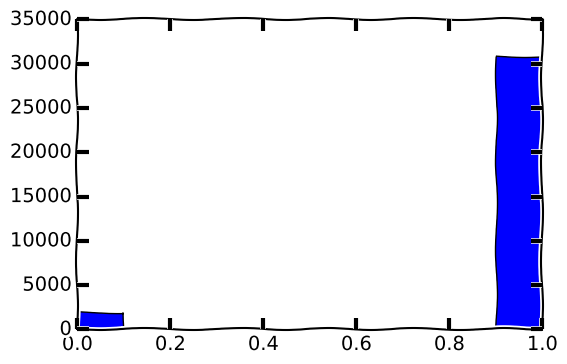

In [32]:
#first thing first, look at the data
plt.xkcd() #makes graphs look better
plt.hist(train['ACTION'])
plt.show()

It appears as if most predictions should be a 1. However, our first submission shows that the test set has many more zeroes than the train set.

Get rid of bad columns.

In [33]:
del train['ROLE_ROLLUP_1']
del train['ROLE_ROLLUP_2']
train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,123472,117905,117906,290919,117908
1,1,17183,1540,123125,118536,118536,308574,118539
2,1,36724,14457,117884,117879,267952,19721,117880
3,1,36135,5396,119993,118321,240983,290919,118322
4,1,42680,5905,119569,119323,123932,19793,119325


In [34]:
del test['ROLE_ROLLUP_1']
del test['ROLE_ROLLUP_2']
test.head()

,id,RESOURCE,MGR_ID,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,78766,72734,117878,117879,118177,19721,117880
1,2,40644,4378,118507,118863,122008,118398,118865
2,3,75443,2395,119488,118172,301534,249618,118175
3,4,43219,19986,118403,120773,136187,118960,120774
4,5,42093,50015,119598,118422,300136,118424,118425


We will assume these new datasets are better bases for classification.

In [35]:
#From Paul Duan
def create_tuples(X):
    cols = []
    for i in range(X.shape[1]):
        for j in range(i, X.shape[1]):
            cols.append(X[:, i] + X[:, j]*3571)
    return np.hstack((X, np.vstack(cols).T))


def create_triples(X):
    cols = []
    for i in range(X.shape[1]):
        for j in range(i, X.shape[1]):
            for k in range(j, X.shape[1]):
                cols.append(X[:, i]*3461 + X[:, j]*5483 + X[:, k])
    return np.hstack((X, np.vstack(cols).T))

#mine
def onehot(x, y):
    enc = preprocessing.OneHotEncoder()
    enc.fit(np.vstack((x, y)))
    return enc.transform(x), enc.transform(y)

In [36]:
#try to make a tuple
tr_x = train.values[:, 1:]
tuple_x = create_tuples(np.vstack((tr_x, test.values[:, 1:])))

In [37]:
tuple_x.shape

(91690, 35)

In [38]:
tr_x.shape

(32769, 7)

In [39]:
tr_x = tuple_x[0:tr_x.shape[0], :]
te_x = tuple_x[tr_x.shape[0]:, :]
print tr_x.shape
print te_x.shape

(32769, 35)
(58921, 35)


In [43]:
#gives mem error, I guess the dataset is too large
enc = preprocessing.OneHotEncoder()
enc.fit(tuple_x)

MemoryError: 

In [44]:
#so we will use the smaller dataset
y = train.values[:, 0]
tr_x = train.values[:, 1:]
test_x = train.values[:, 1:]
enc.fit(np.vstack((tr_x, test_x)))
tr_x = enc.transform(tr_x)
test_x = enc.transform(test_x)

In [45]:
tuptrain_x = tuple_x[0:tr_x.shape[0], :]
tuptest_x = tuple_x[tr_x.shape[0]:, :]

In [ ]:
#boosting
